In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import os
start_token = " "

with open("genera.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [name.lower() for name in names]
    names = [start_token+name for name in names]

In [15]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7901
 abelmoschus
 boodlea
 cyclea
 geitlerinema
 lanxoblatta
 nesiotobacter
 psammomoya
 stenogonum


max length = 25


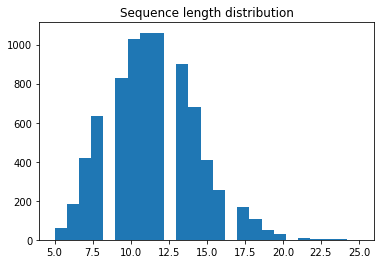

In [16]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25);

In [18]:
#all unique characters go here
tokens = set(''.join(names[:]))

tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)



n_tokens =  27


In [19]:
tokens.sort() # this would put empty line, space ' ' as first (0-index) token. Otherwise all words would end with some character, i.e. BacteriaNamefffffff, padded to the number.

In [20]:
tokens

[' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [21]:
token_to_id = {}

for i in range(n_tokens):
    token_to_id[tokens[i]] = i

In [22]:
token_to_id

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [23]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [24]:
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len,names))
    names_ix = np.zeros([len(names),max_len],dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get,names[i]))
        names_ix[i,:len(name_ix)] = name_ix

    return names_ix.T

In [25]:
print('\n'.join(names[::500]))
print(to_matrix(names[::500]).T)

 abelmoschus
 antarctic
 boodlea
 chelidonium
 cyclea
 echinodontium
 geitlerinema
 himanthalia
 lanxoblatta
 megamonas
 nesiotobacter
 penium
 psammomoya
 salegentibacter
 stenogonum
 trichodesmium
[[ 0  1  2  5 12 13 15 19  3  8 21 19  0  0  0  0]
 [ 0  1 14 20  1 18  3 20  9  3  0  0  0  0  0  0]
 [ 0  2 15 15  4 12  5  1  0  0  0  0  0  0  0  0]
 [ 0  3  8  5 12  9  4 15 14  9 21 13  0  0  0  0]
 [ 0  3 25  3 12  5  1  0  0  0  0  0  0  0  0  0]
 [ 0  5  3  8  9 14 15  4 15 14 20  9 21 13  0  0]
 [ 0  7  5  9 20 12  5 18  9 14  5 13  1  0  0  0]
 [ 0  8  9 13  1 14 20  8  1 12  9  1  0  0  0  0]
 [ 0 12  1 14 24 15  2 12  1 20 20  1  0  0  0  0]
 [ 0 13  5  7  1 13 15 14  1 19  0  0  0  0  0  0]
 [ 0 14  5 19  9 15 20 15  2  1  3 20  5 18  0  0]
 [ 0 16  5 14  9 21 13  0  0  0  0  0  0  0  0  0]
 [ 0 16 19  1 13 13 15 13 15 25  1  0  0  0  0  0]
 [ 0 19  1 12  5  7  5 14 20  9  2  1  3 20  5 18]
 [ 0 19 20  5 14 15  7 15 14 21 13  0  0  0  0  0]
 [ 0 20 18  9  3  8 15  4  5 19 13  

# II. RNN 

<img src="rnnAML.png" width=900>

In [26]:
import keras
from keras.layers import Concatenate,Dense,Embedding

rnn_num_units = 64
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings

#a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation="tanh")

#a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation="softmax")


Using TensorFlow backend.


In [27]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    """
    #convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    #print(tf.shape(x_t_emb)) #Tensor("Shape_16:0", shape=(2,), dtype=int32)
    #print(tf.shape(h_t))    #Tensor("Shape_16:0", shape=(2,), dtype=int32)
    
    #concatenate x embedding and previous h state
    #x_and_h = Concatenate()([x_t_emb, h_t])###YOUR CODE HERE <keras.layers.merge.Concatenate object at 0x7f87e5bfc6a0>
    x_and_h = tf.concat([x_t_emb, h_t], 1)
    #compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    #get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas,h_next

In [28]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) #initial hidden state

for t in range(MAX_LENGTH): #for every time-step 't' ( each character)
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

In [29]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [30]:
from keras.objectives import categorical_crossentropy
loss = tf.reduce_mean(categorical_crossentropy(answers_matrix, predictions_matrix))
optimize = tf.train.AdamOptimizer().minimize(loss)

In [31]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

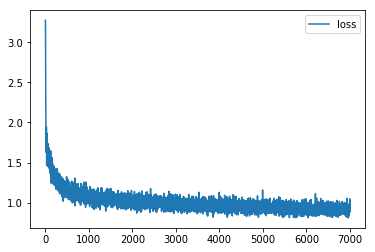

In [38]:
for i in range(5000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

# III. Sampling

In [39]:
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

next_probs,next_h = rnn_one_step(x_t,h_t)

In [40]:
def generate_sample(seed_phrase=None,max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    
    if seed_phrase==None:
        seed_phrase=' '
    else:
        seed_phrase=' ' + str(seed_phrase).strip().lower()
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [41]:
for i in range(3):
    print(str(i+1) + ". " + generate_sample())

1.  snetriobacter           
2.  aceniella               
3.  withonodys              


In [42]:
for i in range(5):
    print(str(i+1) + ". " + generate_sample())

1.  emberria                
2.  pagantiene              
3.  fromotriomndus          
4.  tododestria             
5.  lenia                   


In [43]:
for i in range(3):
    print(str(i+1) + ". " + generate_sample("trump"))

1.  trumphaemantas          
2.  trumphyulus             
3.  trumphyglia             


In [44]:
for i in range(5):
    print(str(i+1) + ". " + generate_sample("trump"))

1.  trumpylochias           
2.  trumprothica            
3.  trumpozix               
4.  trumpsina               
5.  trumpania               


In [45]:
for i in range(10):
    print(str(i+1) + ". " + generate_sample("Kwapich"))

1.  kwapichacdium           
2.  kwapichiritode          
3.  kwapichros              
4.  kwapichzex              
5.  kwapichron              
6.  kwapichemigra           
7.  kwapichoea              
8.  kwapichia               
9.  kwapich la              
10.  kwapichidinar           


# Results

Some of my picks after tampering with generating new examples over and over again :) 

- methynocycomoris
- corevibacter
- temia
- mindomorispora